In [7]:
!nvidia-smi

Fri Sep 11 14:32:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   56C    P2   228W / 280W |  18584MiB / 24220MiB |     80%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 65%   85C    P2   232W / 280W |  13520MiB / 24220MiB |     74%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim

sys.path.append('/home/ironman/abhishek/Fixtures_Data/architectures/')
sys.path.append('/home/ironman/abhishek/Fixtures_Data/Helper/')
from dataloader import mydataset, create_prime_dict 
from ringloss import RingLoss
from cutmix_rl_trainer import train, test_classify, eval_classify
from efficientnet import *
from Load_model import load
from plot_curves import plot_loss, plot_acc

In [4]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


**Dataloading Scheme**

In [5]:
trainlist = "/media/Duamutef/abhishek/Z_A/lists/Only_Matches_training_list.txt"
validlist = "/media/Duamutef/abhishek/Z_A/lists/Only_Matches_validation_list.txt"

In [6]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  438


In [8]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 128, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 64, num_workers=16,pin_memory=True)

**Model Definition**

In [9]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 438)

model = nn.DataParallel(model,device_ids=[4,5]).to(device)
model

Loaded pretrained weights for efficientnet-b4


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

**Hyperparameters**

In [10]:
## Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(device,loss_weight=1.0)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)

# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [11]:
modelpath = '../saved_model_checkpoints/Fixture_Data/Annotated_Matches_AA_Cutout_Cutmix_RL_EB4'

In [12]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler,
      ringloss_block, modelpath, device, epochs = num_Epochs)

loss 4.620878775119781
loss 8.410199056863785
loss 11.92724292755127
loss 15.151999115943909
loss 18.2202523458004
Epoch:  1
training loss =  3.6285711494274437
Validation Loss: 0.8429	Top 1 Validation Accuracy: 0.7787	 Top 5 Validation Accuracy: 0.9469
loss 2.8479625153541566
loss 5.665430870652199
loss 8.397973331809045
loss 11.058246695399284
loss 13.708590817451476
Epoch:  2
training loss =  2.7409307518973947
Validation Loss: 0.5544	Top 1 Validation Accuracy: 0.8543	 Top 5 Validation Accuracy: 0.9733
loss 2.624426735639572
loss 5.265360798239708
loss 7.870624228715896
loss 10.505358139276504
loss 13.047276022434234
Epoch:  3
training loss =  2.6096095298416913
Validation Loss: 0.5077	Top 1 Validation Accuracy: 0.8522	 Top 5 Validation Accuracy: 0.9797
loss 2.4741163074970247
loss 5.02472890496254
loss 7.488601760864258
loss 9.988611249923705
loss 12.45374566733837
Epoch:  4
training loss =  2.4943464681273326
Validation Loss: 0.6238	Top 1 Validation Accuracy: 0.8331	 Top 5 Validat

loss 1.6045424681901932
loss 3.259260013997555
loss 4.913522211015224
loss 6.5259975460171695
loss 8.18005963474512
Epoch:  34
training loss =  1.6390768716228195
Validation Loss: 0.1519	Top 1 Validation Accuracy: 0.9513	 Top 5 Validation Accuracy: 0.9970
loss 1.6374652230739593
loss 3.2470914006233214
loss 4.8744570749998095
loss 6.450329551696777
loss 8.098811684548854
Epoch:  35
training loss =  1.6207959618768655
Validation Loss: 0.1545	Top 1 Validation Accuracy: 0.9491	 Top 5 Validation Accuracy: 0.9965
loss 1.5624679231643677
loss 3.1102475097775457
loss 4.676257028877735
loss 6.291310798823833
loss 7.805793636739254
Epoch:  36
training loss =  1.5633856641943567
Validation Loss: 0.1434	Top 1 Validation Accuracy: 0.9535	 Top 5 Validation Accuracy: 0.9970
loss 1.5698645931482316
loss 3.1394243341684342
loss 4.7233126509189605
loss 6.300168632268906
loss 7.872196713685989
Epoch:  37
training loss =  1.5712258908897638
Validation Loss: 0.1506	Top 1 Validation Accuracy: 0.9503	 Top 5

loss 1.2228265929222106
loss 2.4063604137301446
loss 3.6241187870502474
loss 4.870668194890023
loss 6.049132944643498
Epoch:  66
training loss =  1.20798959833337
Validation Loss: 0.1112	Top 1 Validation Accuracy: 0.9652	 Top 5 Validation Accuracy: 0.9977
loss 1.2108632910251618
loss 2.387456685900688
loss 3.571194932460785
loss 4.772092338502407
loss 5.9448951426148415
Epoch:  67
training loss =  1.189918856951408
Validation Loss: 0.1140	Top 1 Validation Accuracy: 0.9647	 Top 5 Validation Accuracy: 0.9984
loss 1.1322826170921325
loss 2.309458854794502
loss 3.482906833589077
loss 4.695944561064243
loss 5.877617020010948
Epoch:  68
training loss =  1.1760541008552536
Validation Loss: 0.1071	Top 1 Validation Accuracy: 0.9698	 Top 5 Validation Accuracy: 0.9982
loss 1.2056805843114853
loss 2.399914364218712
loss 3.6015218099951745
loss 4.809721140265465
loss 6.0098001900315285
Epoch:  69
training loss =  1.2061020793044008
Validation Loss: 0.1133	Top 1 Validation Accuracy: 0.9655	 Top 5 Va

loss 1.1212124490737916
loss 2.266903030574322
loss 3.4449552047252654
loss 4.596878984570504
loss 5.767786018848419
Epoch:  98
training loss =  1.1518652343074791
Validation Loss: 0.1121	Top 1 Validation Accuracy: 0.9672	 Top 5 Validation Accuracy: 0.9990
loss 1.1215412652492522
loss 2.277567465007305
loss 3.4307178995013237
loss 4.6086650174856185
loss 5.743414599895477
Epoch:  99
training loss =  1.1507869943743572
Validation Loss: 0.1147	Top 1 Validation Accuracy: 0.9627	 Top 5 Validation Accuracy: 0.9982
loss 1.1930852657556534
loss 2.3263475745916367
loss 3.4678293013572694
loss 4.645591363310814
loss 5.780398655831814
Epoch:  100
training loss =  1.159721322299447
Validation Loss: 0.1104	Top 1 Validation Accuracy: 0.9674	 Top 5 Validation Accuracy: 0.9974
loss 1.190557540357113
loss 2.3303567188978196
loss 3.448205507993698
loss 4.598752680122852
loss 5.678745916187763
Epoch:  101
training loss =  1.1397587460814975
Validation Loss: 0.1119	Top 1 Validation Accuracy: 0.9681	 Top 

In [10]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


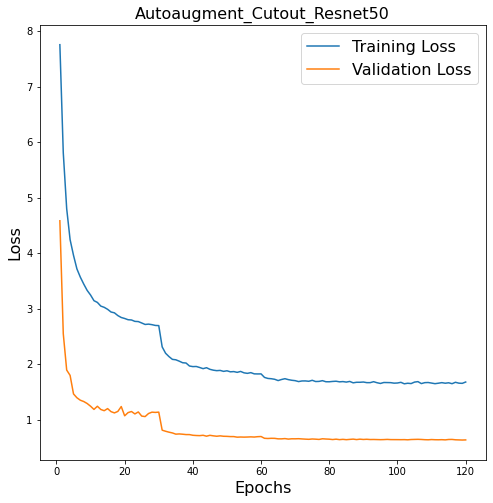

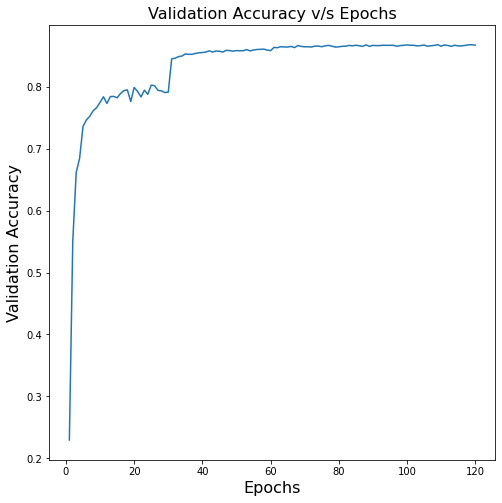

In [11]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'Annotated_Matches_AA_Cutout_Cutmix_RL_EB4')
plot_acc(epoch, v_acc)

In [20]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.4860	Top 1 Training Accuracy: 0.8849	 Top 5 Training Accuracy: 0.9747


In [14]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

Validation Loss: 0.1108	Top 1 Validation Accuracy: 0.9698
Accuracy:defaultdict(<class 'int'>, {'Top 1 Accuracy': 96.97786606129398, 'Top 5 Accuracy': 99.78717366628831, 'Top 10 Accuracy': 99.88649262202043, 'Top 20 Accuracy': 99.92905788876277, 'Top 30 Accuracy': 99.94324631101021, 'Top 50 Accuracy': 99.94324631101021, 'Top 100 Accuracy': 99.97162315550511})	
